In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from lightly.transforms import SimCLRTransform
from lightly.data import LightlyDataset
from lightly.models.modules.heads import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.loss import NegativeCosineSimilarity
from torch.utils.data import DataLoader,Dataset



In [3]:
# Load the saved tensors
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/test_data.pt")

# Access the tensors
index = loaded_data['index']
images = loaded_data['images']
labels = loaded_data['labels']

In [4]:
print(index)

['28.90,77.25_-2_-2' '28.90,77.25_-2_-1' '28.90,77.25_-2_0' ...
 '28.25,77.33_2_0' '28.25,77.33_2_1' '28.25,77.33_2_2']


In [5]:
print(index.shape, images.shape, labels.shape)  
# images=images[:8000]
# labels=labels[:]
# index=index[:2000]
# print(images.shape, labels.shape)
train_images = images[:8000]
train_labels = labels[:8000]
train_index = index[:8000]
test_images = images[8000:]
test_labels = labels[8000:]
test_index = index[8000:]

(10025,) torch.Size([10025, 3, 224, 224]) torch.Size([10025])


In [6]:
#check the shape 
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

torch.Size([8000, 3, 224, 224]) torch.Size([8000])
torch.Size([2025, 3, 224, 224]) torch.Size([2025])


In [7]:
import torchvision.transforms as transforms

train_images = train_images / 255
    # mean normalize
train_images = (train_images - train_images.mean(dim=(0, 2, 3), keepdim=True)) / train_images.std(dim=(0, 2, 3), keepdim=True)
aug = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224,scale=(0.2,1.0)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=50),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
augmentaed_images = aug(train_images) 

/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [9]:
augmentaed_images.shape

torch.Size([8000, 3, 224, 224])

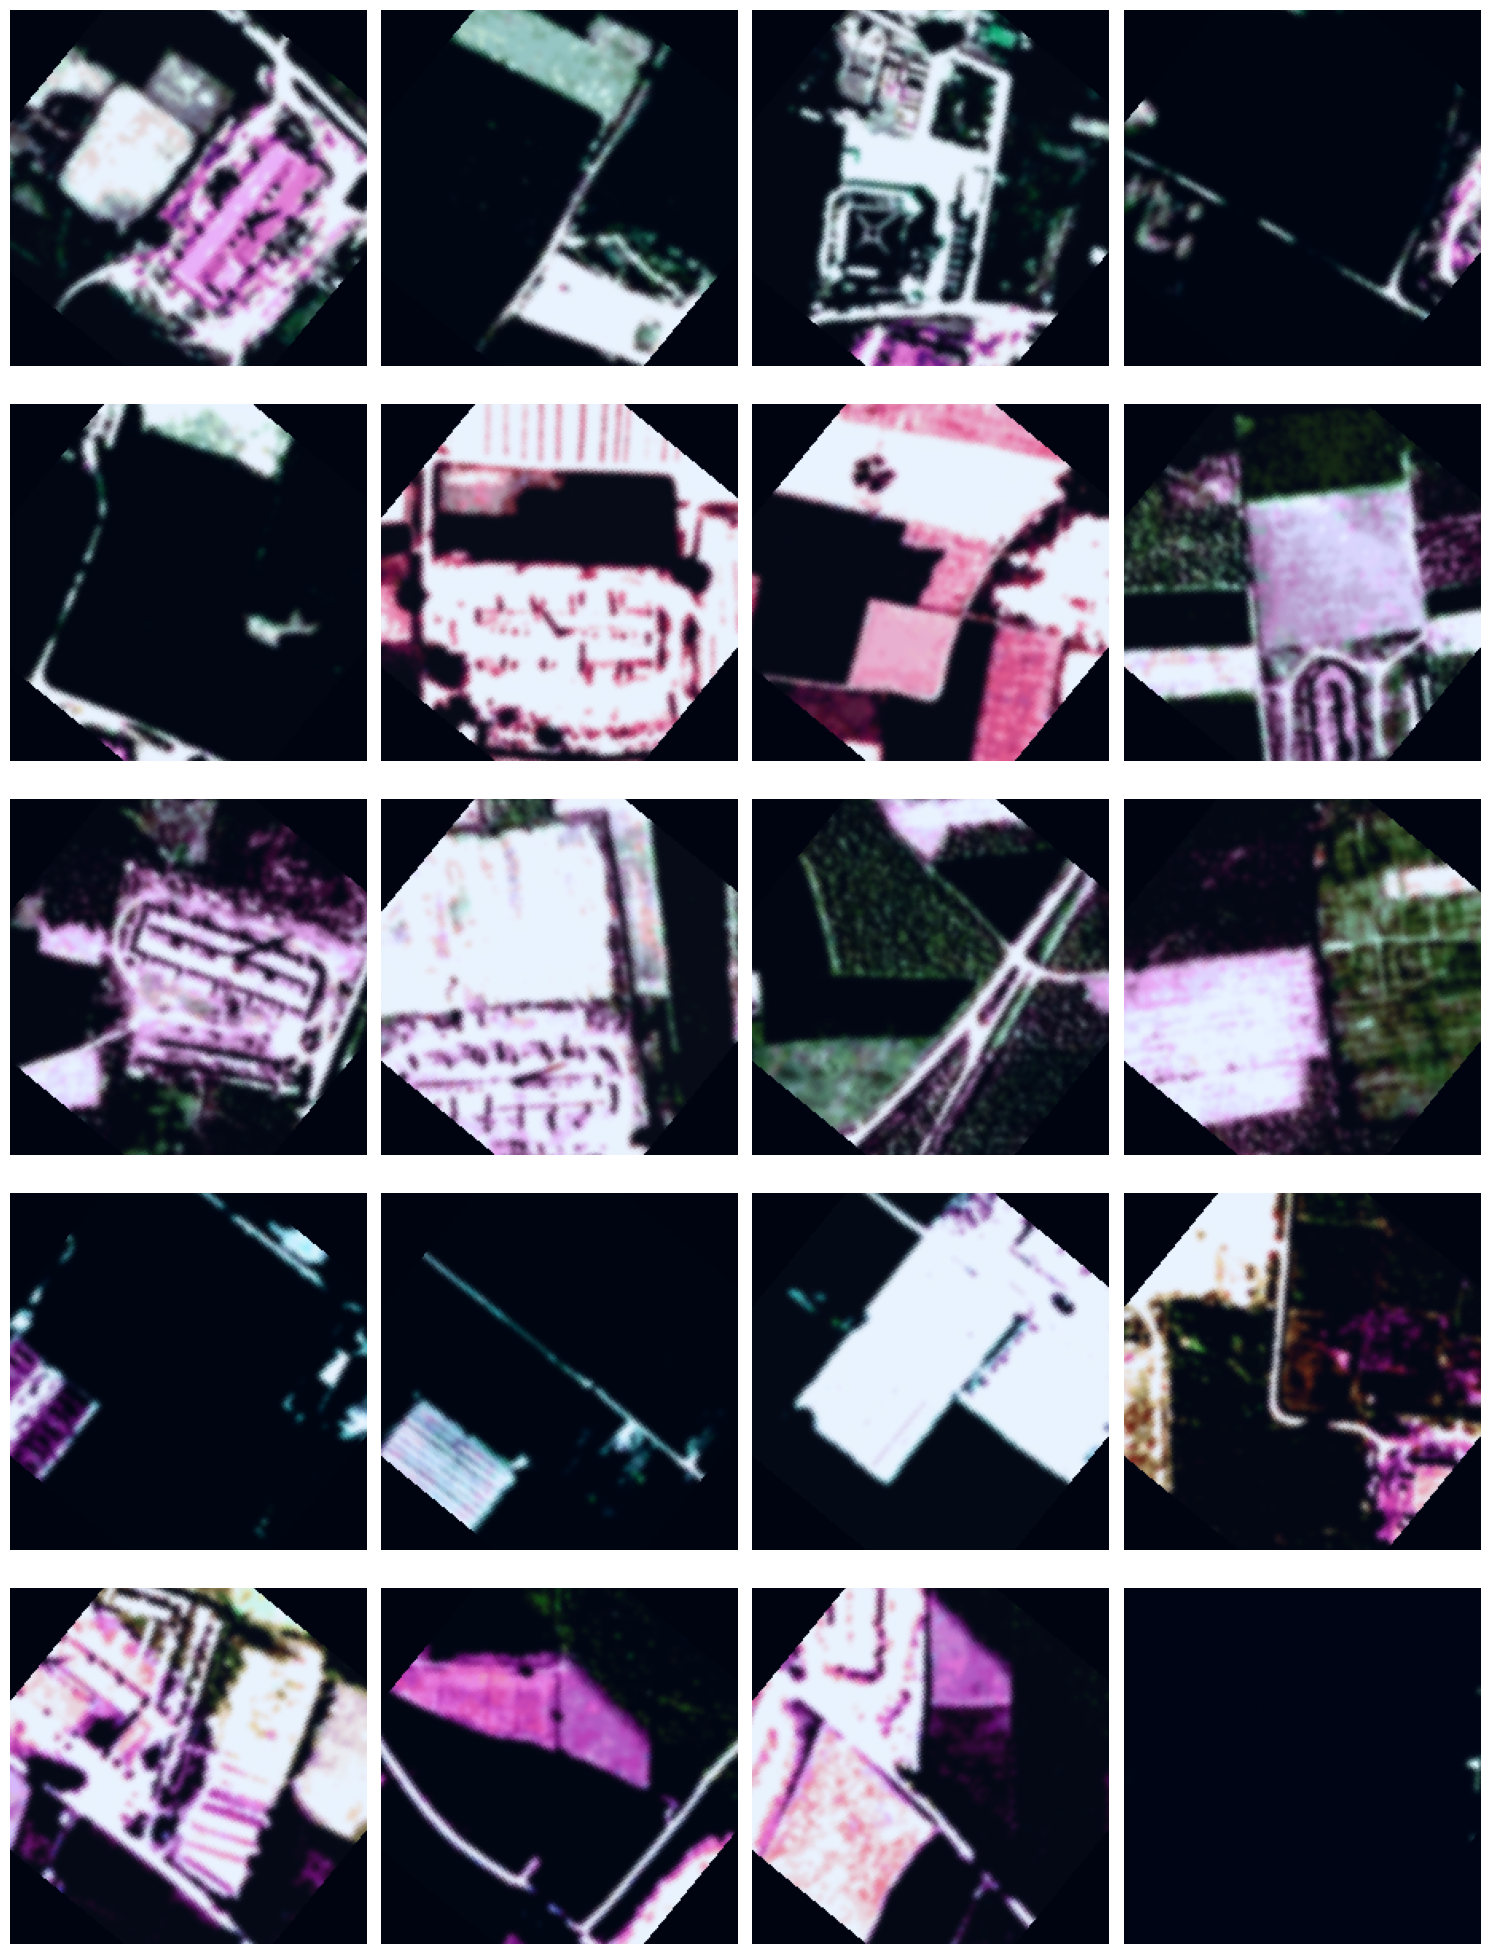

In [10]:
# Filter the images based on the label
label_1_images = augmentaed_images[train_labels == 1]

# Plot the filtered images
fig, axes = plt.subplots(5, 4, figsize=(15,20))

for i in range(5):
    for j in range(4):
        # Adjust the index calculation to match the desired grid
        index = i * 4 + j
        if index < len(label_1_images):
            # Transpose the dimensions to (32, 32, 3) for RGB image
            image_to_display = label_1_images[index].permute(1, 2, 0)
            image_to_display = (image_to_display - image_to_display.min()) / (image_to_display.max() - image_to_display.min())

            axes[i, j].imshow(image_to_display)
            #put the label
            # axes[i, j].set_title(label_1_images[index].item())
            axes[i, j].axis('off')
        else:
            # If there are fewer than 20 images, remove empty subplots
            fig.delaxes(axes[i, j])
plt.tight_layout()
plt.show()


In [11]:
from torch.utils.data import TensorDataset, DataLoader
augmentaed_images1=aug(train_images)
train_data=TensorDataset(augmentaed_images,augmentaed_images1,train_labels)
dataloader_train_simsiam = torch.utils.data.DataLoader(
    train_data,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=8,
)

In [12]:
import torchvision.transforms as transforms

test_images = test_images / 255
    # mean normalize
test_images = (test_images - test_images.mean(dim=(0, 2, 3), keepdim=True)) / test_images.std(dim=(0, 2, 3), keepdim=True)
aug1 = transforms.Compose([
    transforms.Resize(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [13]:
test_images = aug1(test_images)
test_index=[]
for i in range(len(test_images)):
    test_index.append(i)
print(test_index)
test_index=torch.tensor(test_index)
test_data=TensorDataset(test_images,test_labels,test_index)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=8)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

SimSiam model

In [14]:
class SimSiam(nn.Module):
    def __init__(self,backbone,num_ftrs=512,proj_hidden_dim=512,pred_hidden_dim=128,out_dim=128):
        super(SimSiam, self).__init__()
        self.backbone = backbone
        self.projection_head = SimSiamProjectionHead(num_ftrs, proj_hidden_dim, out_dim)
        self.prediction_head = SimSiamPredictionHead(out_dim, pred_hidden_dim, out_dim)

    def forward(self, x):
        #get representation
        f= self.backbone(x).flatten(start_dim=1)
        #get projection
        z=self.projection_head(f)
        #get prediction
        p=self.prediction_head(z)
        #stop gradient
        z = z.detach()
        return z,p

In [15]:
resnet = torchvision.models.resnet18()
print("Resnet",resnet)
backbone = nn.Sequential(*list(resnet.children())[:-1])
print("BAckbone",backbone)
model = SimSiam(backbone, num_ftrs=512, proj_hidden_dim=512, pred_hidden_dim=128, out_dim=512)
print("Model",model)    


Resnet ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=T

In [16]:
batch_size = 128
criterion = NegativeCosineSimilarity()
lr = 0.05 * batch_size / 256
print("Learning rate",lr)   
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)


Learning rate 0.025


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
avg_loss = 0.0    
avg_output_std = 0.0
epochs = 50

for e in range(epochs):
    for x0, x1, _ in dataloader_train_simsiam:
        # move images to the gpu
        # print("X0",x0.shape)
        # print("X1",x1.shape)
        x0 = x0.to(device)
        x1 = x1.to(device)
        zo,po = model(x0)
        # print("Zo",zo.shape)
        # print("Po",po.shape)
        z1,p1 = model(x1)
        # print("Z1",z1.shape)
        # print("P1",p1.shape)
        loss=0.5*(criterion(zo,p1)+criterion(z1,po))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        output=po.detach()
        output=torch.nn.functional.normalize(output,dim=1)
        output_std=torch.std(output, dim=0)
        avg_output_std += output_std.mean()
        w=0.9
        avg_loss = w*avg_loss + (1-w)*loss.item()
    print(
        f"[Epoch {e:3d}] "
        f"Loss = {avg_loss:.2f} | "
    )


[Epoch   0] Loss = -0.74 | 
[Epoch   1] Loss = -0.90 | 
[Epoch   2] Loss = -0.93 | 
[Epoch   3] Loss = -0.94 | 
[Epoch   4] Loss = -0.95 | 
[Epoch   5] Loss = -0.95 | 
[Epoch   6] Loss = -0.96 | 
[Epoch   7] Loss = -0.96 | 
[Epoch   8] Loss = -0.96 | 
[Epoch   9] Loss = -0.97 | 
[Epoch  10] Loss = -0.97 | 
[Epoch  11] Loss = -0.97 | 
[Epoch  12] Loss = -0.98 | 
[Epoch  13] Loss = -0.98 | 
[Epoch  14] Loss = -0.98 | 
[Epoch  15] Loss = -0.98 | 
[Epoch  16] Loss = -0.98 | 
[Epoch  17] Loss = -0.98 | 
[Epoch  18] Loss = -0.98 | 
[Epoch  19] Loss = -0.98 | 
[Epoch  20] Loss = -0.98 | 
[Epoch  21] Loss = -0.98 | 
[Epoch  22] Loss = -0.98 | 
[Epoch  23] Loss = -0.98 | 
[Epoch  24] Loss = -0.98 | 
[Epoch  25] Loss = -0.98 | 
[Epoch  26] Loss = -0.98 | 
[Epoch  27] Loss = -0.98 | 
[Epoch  28] Loss = -0.98 | 
[Epoch  29] Loss = -0.98 | 
[Epoch  30] Loss = -0.98 | 
[Epoch  31] Loss = -0.98 | 
[Epoch  32] Loss = -0.98 | 
[Epoch  33] Loss = -0.98 | 
[Epoch  34] Loss = -0.98 | 
[Epoch  35] Loss = -

In [18]:
embeddings = []
filenames = []
model.eval()
with torch.no_grad():
    for i, (x, _, index) in enumerate(test_loader):
        x = x.to(device)
        y=model.backbone(x).flatten(start_dim=1)
        embeddings.append(y)
        filenames.append(index)
embeddings=torch.cat(embeddings,dim=0)
embeddings = embeddings.cpu().numpy()

In [19]:
print (y.shape)

torch.Size([105, 512])


In [20]:
# for plotting
import os

import matplotlib.offsetbox as osb
import matplotlib.pyplot as plt

# for resizing images to thumbnails
import torchvision.transforms.functional as functional
from matplotlib import rcParams as rcp
from PIL import Image

# for clustering and 2d representations
from sklearn import random_projection

In [21]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

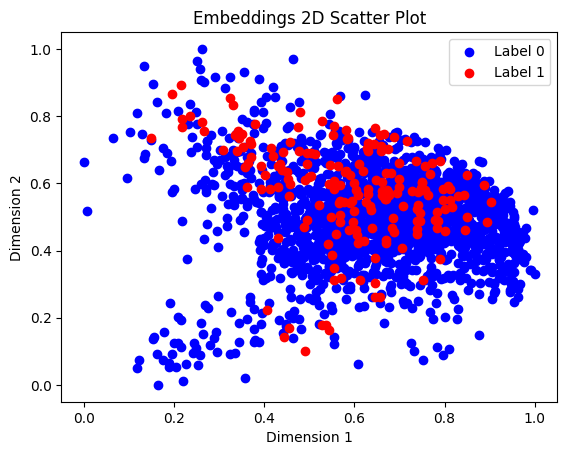

In [22]:
import matplotlib.pyplot as plt

# Separate the embeddings based on their labels
label_0_embeddings = embeddings_2d[test_labels == 0]
label_1_embeddings = embeddings_2d[test_labels == 1]

# Plot the embeddings with different colors
plt.scatter(label_0_embeddings[:, 0], label_0_embeddings[:, 1], c='blue', label='Label 0')
plt.scatter(label_1_embeddings[:, 0], label_1_embeddings[:, 1], c='red', label='Label 1')

plt.title("Embeddings 2D Scatter Plot")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()


In [23]:
from torchvision.transforms import ToTensor, ToPILImage


In [24]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays."""
    # initialize empty figure and add subplot
    fig = plt.figure()
    fig.suptitle("Scatter Plot")
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1.0, 1.0]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp["figure.figsize"][0] * 2.0)
        # Assuming test_images[idx] is a tensor representing an image
        img_np = test_images[idx].permute(1, 2, 0).cpu().numpy()

        # Convert the NumPy array to a PIL Image
        img = Image.fromarray((img_np * 255).astype(np.uint8))

        # Resize the image using interpolate
        img = F.interpolate(ToTensor()(img).unsqueeze(0), size=(thumbnail_size, thumbnail_size), mode='nearest').squeeze(0)
        img = ToPILImage()(img)

        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1.0 / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable="box")

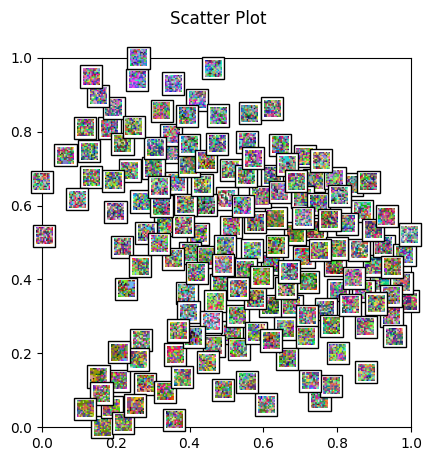

In [25]:
get_scatter_plot_with_thumbnails()


In [26]:
from PIL import Image
import numpy as np
import torchvision.transforms as transforms



In [27]:
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [28]:
finetune_train=images[:4000]
finetune_labels=labels[:4000]
# finetune_index=index[:4000]
finetune_test=images[4000:]
finetune_test_labels=labels[4000:]
# finetune_test_index=index[4000:]
print(finetune_train.shape,finetune_labels.shape)
print(finetune_test.shape,finetune_test_labels.shape)
finetune_train = finetune_train / 255
    # mean normalize
finetune_train = (finetune_train - finetune_train.mean(dim=(0, 2, 3), keepdim=True)) / finetune_train.std(dim=(0, 2, 3), keepdim=True)
finetune_train=aug(finetune_train)
finetune_test = finetune_test / 255
    # mean normalize
finetune_test = (finetune_test - finetune_test.mean(dim=(0, 2, 3), keepdim=True)) / finetune_test.std(dim=(0, 2, 3), keepdim=True)
finetune_test=aug1(finetune_test)





torch.Size([4000, 3, 224, 224]) torch.Size([4000])
torch.Size([6025, 3, 224, 224]) torch.Size([6025])


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [29]:
finetune_dataset=TensorDataset(finetune_train,finetune_labels)
finetune_test_dataset=TensorDataset(finetune_test,finetune_test_labels)
finetune_loader = DataLoader(finetune_dataset, batch_size=128, shuffle=True, num_workers=8)
finetune_test_loader = DataLoader(finetune_test_dataset, batch_size=128, shuffle=False, num_workers=8)

In [30]:
classifier = Classifier(input_dim=512, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
num_epochs = 50
for epochs in range(num_epochs):
    for x, y in finetune_loader:
        x = x.to(device)
        y = y.to(device)
        f1,p1=model(x)
        # f1=model.backbone(x).flatten(start_dim=1)
        # z1=model.projection_head(f1)
        # p1=model.prediction_head(z1)
        # print("z1",z1.shape)
        # print("P1",p1.shape)
        classifier.train()
        optimizer.zero_grad()
        output = classifier(p1)
        # print("output",output.shape)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epochs + 1}/{num_epochs}], Classifier Loss: {loss.item():.4f}')





    


Epoch [1/50], Classifier Loss: 0.3218
Epoch [2/50], Classifier Loss: 0.1851
Epoch [3/50], Classifier Loss: 0.5363
Epoch [4/50], Classifier Loss: 0.2327
Epoch [5/50], Classifier Loss: 0.3898
Epoch [6/50], Classifier Loss: 0.3572
Epoch [7/50], Classifier Loss: 0.3174
Epoch [8/50], Classifier Loss: 0.3390
Epoch [9/50], Classifier Loss: 0.5144
Epoch [10/50], Classifier Loss: 0.2189
Epoch [11/50], Classifier Loss: 0.3252
Epoch [12/50], Classifier Loss: 0.1836
Epoch [13/50], Classifier Loss: 0.2705
Epoch [14/50], Classifier Loss: 0.2535
Epoch [15/50], Classifier Loss: 0.5244
Epoch [16/50], Classifier Loss: 0.6141
Epoch [17/50], Classifier Loss: 0.3876
Epoch [18/50], Classifier Loss: 0.2688
Epoch [19/50], Classifier Loss: 0.5468
Epoch [20/50], Classifier Loss: 0.1758
Epoch [21/50], Classifier Loss: 0.1799
Epoch [22/50], Classifier Loss: 0.4756
Epoch [23/50], Classifier Loss: 0.2157
Epoch [24/50], Classifier Loss: 0.5227
Epoch [25/50], Classifier Loss: 0.2890
Epoch [26/50], Classifier Loss: 0.

In [31]:
classifier.eval()
all_predictions = []
all_targets = []
with torch.no_grad():
    for batch in finetune_test_loader:
        inputs, targets = batch
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        f11=model.backbone(inputs).flatten(start_dim=1)
        z11=model.projection_head(f11)
        p11=model.prediction_head(z11)
        outputs = classifier(p11)
        predictions=torch.argmax(outputs,dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
all_predictions = np.array(all_predictions)
all_labels = np.array(all_targets)
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have the predictions and ground truth labels from the previous code

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute and display classification report
class_report = classification_report(all_targets, all_predictions)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[5474    0]
 [ 551    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5474
           1       0.00      0.00      0.00       551

    accuracy                           0.91      6025
   macro avg       0.45      0.50      0.48      6025
weighted avg       0.83      0.91      0.87      6025



/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa